# RTA workload

The RTA or RTApp workload represents a type of workload obtained using the rt-app test application.
More details on the test application can be found at https://github.com/scheduler-tools/rt-app.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup(level=0)

2018-01-19 10:44:01,910 INFO    : root         : Using LISA logging configuration:
2018-01-19 10:44:01,922 INFO    : root         :   /home/leoy/Work/tools/lisa-ml-20171106/logging.conf


In [2]:
# Generate plots inline
%pylab inline

import json
import os

# Support to initialise and configure your test environment
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp, Step, Pulse

# Suport for FTrace events parsing and visualization
import trappy

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

%matplotlib inline

import devlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import trappy

from collections import OrderedDict
from csv import DictWriter
from env import TestEnv
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.stats import linregress
from scipy import polyfit
from time import sleep
from trappy.plotter.ColorMap import ColorMap

# Support for trace events analysis
from trace import Trace
# Import support for Android devices
from android import Screen, Workload, System

Populating the interactive namespace from numpy and matplotlib


2018-01-19 10:44:03,402 DEBUG   : JsonConf     : loading JSON...
2018-01-19 10:44:03,403 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-01-19 10:44:03,404 DEBUG   : JsonConf     :    {u'board': {u'big_core': u'A15', u'cores': [u'A7', u'A7', u'A7', u'A7', u'A15', u'A15', u'A15', u'A15'], u'modules': [u'bl', u'cpufreq']}}
2018-01-19 10:44:03,406 DEBUG   : JsonConf     : loading JSON...
2018-01-19 10:44:03,409 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-01-19 10:44:03,410 DEBUG   : JsonConf     :    {u'nrg_model': {u'big': {u'cluster': {u'nrg_max': 78}, u'cpu': {u'cap_max': 1024, u'nrg_max': 1893}}, u'little': {u'cluster': {u'nrg_max': 56}, u'cpu': {u'cap_max': 472, u'nrg_max': 215}}}, u'board': {u'big_core': u'A72', u'cores': [u'A53', u'A53', u'A53', u'A53', u'A72', u'A72'], u'modules': [u'bl', u'cpufreq', u'cpuidle']}}
2018-01-19 10:44:03,411 DEBUG   : JsonConf     : loading JSON...
2018-01-19 10:44:03,412 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-0

## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Energy Meters Configuration for BayLibre's ACME Cape
    "emeter" : {
        "instrument" : "aep",
        "conf" : {
            'resistor_values' : [0.033],
            'device_entry'    : '/dev/ttyACM0'
        },
        "channel_map" : {
            "Device0" : "BAT"
        }
    },
    
    # Preload settings for a specific target
    "board"       : 'hikey960',  # juno - JUNO board with mainline hwmon
    
    "device"      : "2450309301A1C7FB",
    
    "modules" : ['cpufreq', 'cpuidle', 'hotplug', 'cgroups', 'thermal', 'cpufreq'],

    "results_dir" : "scheduling_duration_opt",
    
    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
         '0': 302, '1': 301, '2': 304, '3': 301, '4': 136, '5': 136, '6': 137, '7': 136
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "cpu_frequency",
             "sched_energy_calc_duration"
         ],
         "buffsize" : 10240
    },

}

In [4]:
# Initialize a test environment using
# - the provided target configuration (my_target_conf)
# - the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-01-19 10:44:04,185 INFO    : TestEnv      : Using base path: /home/leoy/Work/tools/lisa-ml-20171106
2018-01-19 10:44:04,187 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-01-19 10:44:04,189 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-01-19 10:44:04,192 INFO    : TestEnv      : External tools using:
2018-01-19 10:44:04,194 INFO    : TestEnv      :    ANDROID_HOME: /home/leoy/Android/Sdk/
2018-01-19 10:44:04,198 INFO    : TestEnv      :    CATAPULT_HOME: /home/leoy/Work/tools/lisa-ml-20171106/tools/catapult
2018-01-19 10:44:04,201 INFO    : TestEnv      : Devlib modules to load: ['cgroups', 'cpufreq', 'bl', 'hotplug', 'thermal', 'cpuidle']
2018-01-19 10:44:04,203 INFO    : TestEnv      : Connecting Android target [2450309301A1C7FB]
2018-01-19 10:44:04,205 INFO    : TestEnv      : Connection settings:
2018-01-19 10:44:04,209 INFO    : TestEnv      :    {'device': '2450309301A1C7FB'}
2018-01-19 10:44:05,621 DEBUG   : cpuidle    

2018-01-19 10:44:08,441 DEBUG   : cgroups.debug : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh0
2018-01-19 10:44:08,498 INFO    : CGroups      :   debug        : /data/local/tmp/devlib-target/cgroups/devlib_cgh0
2018-01-19 10:44:10,493 INFO    : TestEnv      : Attempting to read energy model from target
2018-01-19 10:44:11,125 INFO    : TestEnv      : Topology:
2018-01-19 10:44:11,126 INFO    : TestEnv      :    [[0, 1, 2, 3], [4, 5, 6, 7]]
2018-01-19 10:44:11,251 INFO    : TestEnv      : Loading default EM:
2018-01-19 10:44:11,253 INFO    : TestEnv      :    /home/leoy/Work/tools/lisa-ml-20171106/libs/utils/platforms/hikey960.json
2018-01-19 10:44:11,254 DEBUG   : JsonConf     : loading JSON...
2018-01-19 10:44:11,257 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-01-19 10:44:11,259 DEBUG   : JsonConf     :    {u'abi': u'arm64', u'freqs': {u'1': [903000, 1421000, 1805000, 2112000, 2362000], u'0': [533000, 999000, 1402000, 1709000, 1844000]}, u'board': {u'

## Workload configuration

To create an instance of an RTApp workload generator you need to provide the following:
- target: target device configuration
- name: name of workload. This is the name of the JSON configuration file reporting the generated RTApp configuration.
- calibration: CPU load calibration values, measured on each core.

An RTApp workload is defined by specifying a **kind**, provided below through **rtapp.conf**, which represents the way we want to define the behavior of each task.
The possible kinds of workloads are **profile** and **custom**. It's very important to notice that **periodic** is no longer considered a "kind" of workload but a "class" within the **profile** kind.
<br><br>
As you see below, when "kind" is "profile", the tasks generated by this workload have a profile which is defined by a sequence of phases. These phases are defined according to the following grammar:<br>
 - params := {task, ...} <br>
 - task   := NAME : {SCLASS, PRIO, [phase, ...]}<br>
 - phase  := (PTIME, PERIOD, DCYCLE)<br> <br>
 
There are some pre-defined task classes for the **profile** kind:
 - **Step**: the load of this task is a step with a configured initial and final load. 
 - **Pulse**: the load of this task is a pulse with a configured initial and final load.The main difference with the 'step' class is that a pulse workload is by definition a 'step down', i.e. the workload switches from an initial load to a final one which is always lower than the initial one. Moreover, a pulse load does not generate a sleep phase in case of 0[%] load, i.e. the task ends as soon as the non null initial load has completed.
 - **Ramp**: the load of this task is a ramp with a configured number of steps determined by the input parameters.
 - **Periodic**: the load of this task is periodic with a configured period and duty-cycle.<br><br>
The one below is a workload mix having all types of workloads described above, but each of them can also be specified serapately in the RTApp parameters. 

In [36]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 10:54:05,496 INFO    : Workload     : Setup new workload simple
2018-01-19 10:54:05,581 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 10:54:05,583 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 10:54:05,584 INFO    : Workload     : ------------------------
2018-01-19 10:54:05,585 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 10:54:05,587 INFO    : Workload     :  | loops count: 1
2018-01-19 10:54:05,588 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 10:54:05,589 INFO    : Workload     : |  period     5000 [us], duty_cycle   1 %
2018-01-19 10:54:05,590 INFO    : Workload     : |  run_time     50 [us], sleep_time   4950 [us]


The output of the previous cell reports the main properties of the generated
tasks. Thus for example we see that the first task is configure to be:
 - named **task_per20**
 - executed as a **SCHED_FIFO** task
 - generating a load which is **calibrated** with respect to the **CPU 1**
 - with one single "phase" which defines a peripodic load for the **duration** of **5[s]**
 - that periodic load consistes of **50 cycles**
 - each cycle has a **period** of **100[ms]** and a **duty-cycle** of **20%**,
   which means that the task, for every cycle, will **run** for **20[ms]** and then sleep for **80[ms]** 

All these properties are translated into a JSON configuration file for RTApp which you can see in **Collected results** below.<br>

## Workload execution

In [37]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 10:54:06,647 INFO    : root         : #### Setup FTrace
2018-01-19 10:54:09,809 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 10:54:09,904 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 10:54:10,023 INFO    : root         : #### Start energy sampling
2018-01-19 10:54:10,024 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-jb1Kod
2018-01-19 10:54:10,038 INFO    : root         : #### Start RTApp execution
2018-01-19 10:54:10,041 INFO    : Workload     : Workload execution START:
2018-01-19 10:54:10,042 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 10:54:20,266 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-01-19 10:54:20,268 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-jb1Kod/0000000000
2018-01-19 10:54:20,641 INFO    : root         : #### Stop FTrace
2018-01-19 10:54:20,642 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 10:54:20,855 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-01-19 10:54:22,776 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


## Collected results

In [26]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

2018-01-19 10:53:18,039 INFO    : root         : Generated RTApp JSON file:


{
    "global": {
        "calibration": 136, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/data/local/tmp/devlib-target"
    }, 
    "tasks": {
        "task_per5": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 1000, 
                    "run": 100, 
                    "timer": {
                        "period": 10000, 
                        "ref": "task_per5"
                    }
                }
            }, 
            "policy": "SCHED_OTHER"
        }
    }
}


In [27]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

2018-01-19 10:53:18,192 INFO    : root         : Content of the output folder /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt


total 6656
drwxrwxr-x  3 leoy leoy    4096 Jan 19 10:53 .
drwxrwxr-x 12 leoy leoy    4096 Jan 19 10:44 ..
-rw-rw-r--  1 leoy leoy      37 Jan 19 10:53 energy.json
-rw-rw-r--  1 leoy leoy     170 Jan 19 10:53 output.log
-rw-rw-r--  1 leoy leoy    1527 Jan 19 10:53 platform.json
-rw-r--r--  1 leoy leoy  124160 Jan 19 10:53 rt-app-task_per5-0.log
-rw-rw-r--  1 leoy leoy 1851388 Jan 19 10:53 samples.csv
-rw-r--r--  1 leoy leoy     571 Jan 19 10:53 simple_00.json
-rw-rw-r--  1 leoy leoy   50231 Jan 19 10:46 task_perf_task_per5.png
-rw-r--r--  1 leoy leoy 4755456 Jan 19 10:53 trace.dat
drwxrwxr-x  2 leoy leoy    4096 Jan 19 10:49 .trace.dat.cache


In [28]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

2018-01-19 10:53:18,335 INFO    : root         : Energy: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json


{
    "Device0": 27.205571924303829
}


In [29]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
print json.dumps(plt, indent=4, sort_keys=True)

2018-01-19 10:53:18,477 INFO    : root         : Platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


{
    "abi": "arm64", 
    "clusters": {
        "big": [
            4, 
            5, 
            6, 
            7
        ], 
        "little": [
            0, 
            1, 
            2, 
            3
        ]
    }, 
    "cpus_count": 8, 
    "freqs": {
        "big": [
            903000, 
            1421000, 
            1805000, 
            2112000, 
            2362000
        ], 
        "little": [
            533000, 
            999000, 
            1402000, 
            1709000, 
            1844000
        ]
    }, 
    "kernel": {
        "major": 9, 
        "minor": 74, 
        "parts": [
            4, 
            9, 
            74
        ], 
        "rc": null, 
        "release": "4.9.74-04142-gf7518aa", 
        "sha1": "f7518aa", 
        "version": "104 SMP PREEMPT Fri Jan 19 10:42:33 CST 2018", 
        "version_number": 4
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 433
            }, 
        

In [ ]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            903000,
            1421000,
            1805000,
            2112000,
            2362000
        ],
        'little': [
            533000,
            999000,
            1402000,
            1709000,
            1844000]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 559
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 4269
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 181
            },
            'cpu': {
                'cap_max': 466,
                'nrg_max': 731
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

## 1% Workload

More information on visualization and trace inspection can be found in **examples/trappy**.

In [44]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:26:12,856 INFO    : Workload     : Setup new workload simple
2018-01-19 11:26:12,940 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:26:12,942 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:26:12,944 INFO    : Workload     : ------------------------
2018-01-19 11:26:12,945 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:26:12,946 INFO    : Workload     :  | loops count: 1
2018-01-19 11:26:12,948 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:26:12,949 INFO    : Workload     : |  period     5000 [us], duty_cycle   1 %
2018-01-19 11:26:12,951 INFO    : Workload     : |  run_time     50 [us], sleep_time   4950 [us]


In [45]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:26:12,997 INFO    : root         : #### Setup FTrace
2018-01-19 11:26:16,201 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:26:16,271 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:26:16,397 INFO    : root         : #### Start energy sampling
2018-01-19 11:26:16,399 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-jb1Kod
2018-01-19 11:26:16,411 INFO    : root         : #### Start RTApp execution
2018-01-19 11:26:16,417 INFO    : Workload     : Workload execution START:
2018-01-19 11:26:16,418 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:26:26,624 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-01-19 11:26:26,626 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-jb1Kod/0000000000
2018-01-19 11:26:26,984 INFO    : root         : #### Stop FTrace
2018-01-19 11:26:26,985 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:26:27,257 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-01-19 11:26:29,318 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [46]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

## RTApp task performance plots

2018-01-19 11:26:30,547 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:26:30,548 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:26:30,777 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.85, std: 0.03


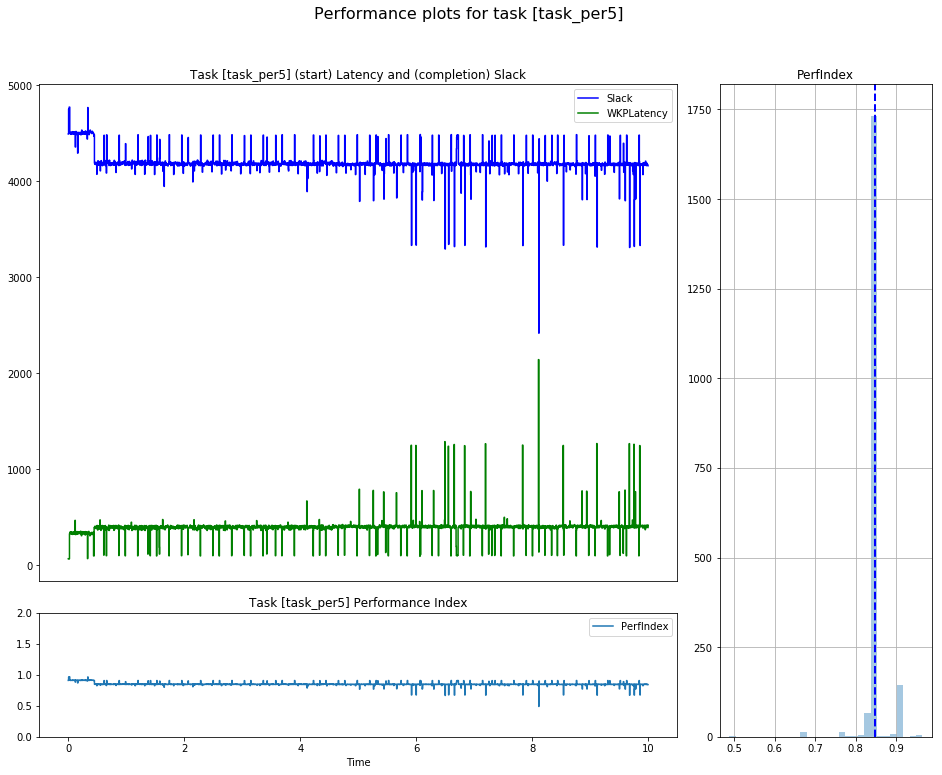

In [47]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [48]:
# Analyse CPU utilization standard devation
def analysis_energy_calculation_duration():

    df = trace.data_frame.trace_event('sched_energy_calc_duration')
    
    if df.empty:
        return
    
    calc_duration_df = pd.DataFrame(
        {
            'max': [int(df['duration'].max())],
            'min': [int(df['duration'].min())],
            'mean': [int(df['duration'].mean())],
        },
    )
    
    return calc_duration_df

In [49]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:26:32,091 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-01-19 11:26:32,093 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:26:32,096 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f84b19e6790> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f84b0092d50> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 11:26:32,636 DEBUG   : Trace        : Events found o

2018-01-19 11:26:32,793 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:26:32,794 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f84b1adf910>] local data frames
2018-01-19 11:26:32,794 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:26:32,795 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:26:32,797 DEBUG   : Trace        :    trace_event
2018-01-19 11:26:32,797 DEBUG   : Analysis     :    frequency
2018-01-19 11:26:32,798 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:26:32,799 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f84b1adf890>] local data frames
2018-01-19 11:26:32,800 DEBUG   : Trace        :    activations_df
2018-01-19 11:26:32,801 DEBUG   : Trace        :    latency_df
2018-01-19 11:26:32,802 DEBUG   : Trace        :    latency_preemption_df
2018-01-19 11:26:32,803 DEBUG   : Trace        :    latency_wakeup_df
2018

In [50]:
analysis_energy_calculation_duration()

,max,mean,min
0,31771,8457,2083


# 5% workload

In [51]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=5,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:26:32,945 INFO    : Workload     : Setup new workload simple
2018-01-19 11:26:33,034 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:26:33,036 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:26:33,037 INFO    : Workload     : ------------------------
2018-01-19 11:26:33,039 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:26:33,040 INFO    : Workload     :  | loops count: 1
2018-01-19 11:26:33,041 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:26:33,042 INFO    : Workload     : |  period     5000 [us], duty_cycle   5 %
2018-01-19 11:26:33,043 INFO    : Workload     : |  run_time    250 [us], sleep_time   4750 [us]


In [52]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:26:33,094 INFO    : root         : #### Setup FTrace
2018-01-19 11:26:36,290 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:26:36,377 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:26:36,478 INFO    : root         : #### Start energy sampling
2018-01-19 11:26:36,479 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-jb1Kod
2018-01-19 11:26:36,494 INFO    : root         : #### Start RTApp execution
2018-01-19 11:26:36,496 INFO    : Workload     : Workload execution START:
2018-01-19 11:26:36,498 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:26:46,668 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-01-19 11:26:46,670 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-jb1Kod/0000000000
2018-01-19 11:26:47,010 INFO    : root         : #### Stop FTrace
2018-01-19 11:26:47,011 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:26:47,248 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-01-19 11:26:49,141 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [53]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-01-19 11:26:50,450 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:26:50,451 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:26:50,675 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.61, std: 0.02


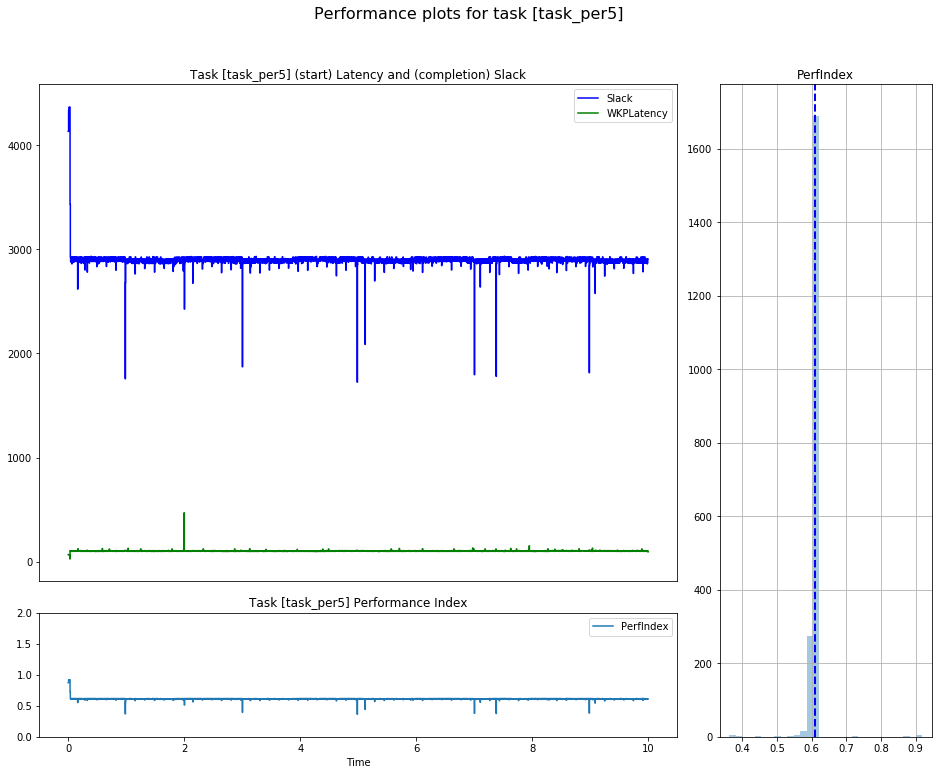

In [54]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [55]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:26:51,738 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-01-19 11:26:51,742 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:26:51,745 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f84b190a550> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f84b190ac50> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 11:26:52,329 DEBUG   : Trace

2018-01-19 11:26:52,510 DEBUG   : Analysis     :    idle
2018-01-19 11:26:52,511 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:26:52,513 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f84b0fcb810>] local data frames
2018-01-19 11:26:52,515 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:26:52,517 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:26:52,518 DEBUG   : Trace        :    trace_event
2018-01-19 11:26:52,520 DEBUG   : Analysis     :    frequency
2018-01-19 11:26:52,521 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:26:52,522 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f84b0fcb950>] local data frames
2018-01-19 11:26:52,523 DEBUG   : Trace        :    activations_df
2018-01-19 11:26:52,524 DEBUG   : Trace        :    latency_df
2018-01-19 11:26:52,525 DEBUG   : Trace        :    latency_preemption_df
2018-01-19 11:26:

In [56]:
analysis_energy_calculation_duration()

,max,mean,min
0,30209,9534,1562


# 10% workload

In [57]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=10,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:26:52,663 INFO    : Workload     : Setup new workload simple
2018-01-19 11:26:52,748 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:26:52,750 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:26:52,752 INFO    : Workload     : ------------------------
2018-01-19 11:26:52,753 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:26:52,754 INFO    : Workload     :  | loops count: 1
2018-01-19 11:26:52,755 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:26:52,756 INFO    : Workload     : |  period     5000 [us], duty_cycle  10 %
2018-01-19 11:26:52,757 INFO    : Workload     : |  run_time    500 [us], sleep_time   4500 [us]


In [58]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:26:52,808 INFO    : root         : #### Setup FTrace
2018-01-19 11:26:55,869 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:26:55,952 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:26:56,089 INFO    : root         : #### Start energy sampling
2018-01-19 11:26:56,091 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-jb1Kod
2018-01-19 11:26:56,104 INFO    : root         : #### Start RTApp execution
2018-01-19 11:26:56,106 INFO    : Workload     : Workload execution START:
2018-01-19 11:26:56,107 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:27:06,279 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-01-19 11:27:06,282 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-jb1Kod/0000000000
2018-01-19 11:27:06,644 INFO    : root         : #### Stop FTrace
2018-01-19 11:27:06,645 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:27:06,797 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-01-19 11:27:08,708 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [59]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-01-19 11:27:10,010 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:27:10,011 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:27:10,255 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.48, std: 0.20


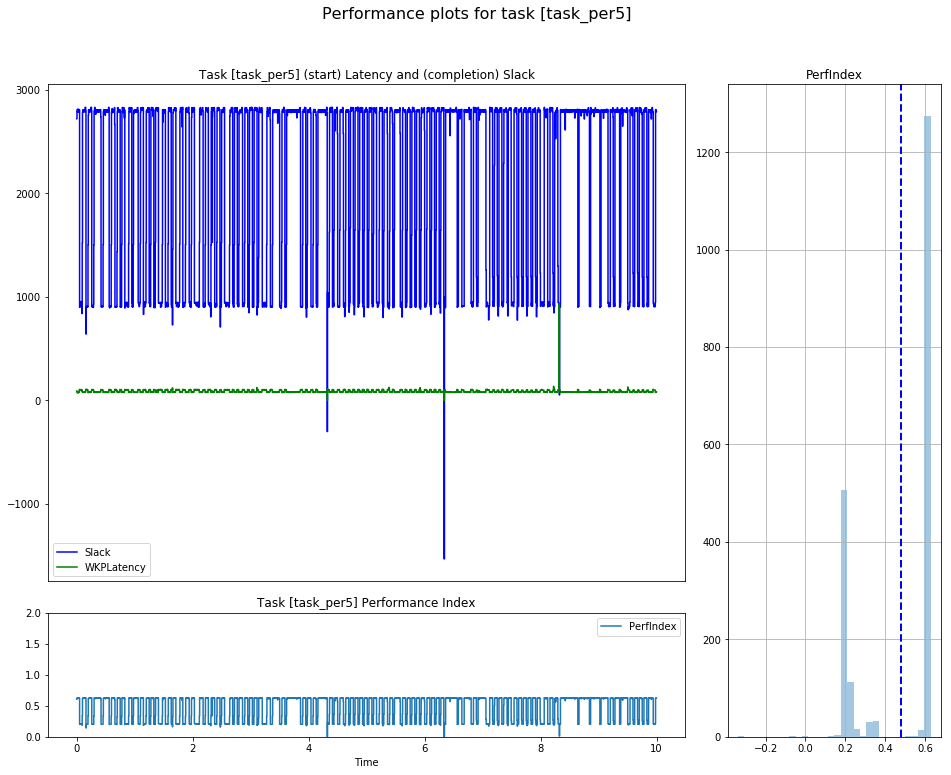

In [60]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [61]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:27:11,638 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-01-19 11:27:11,647 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:27:11,649 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f84b0d23e90> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f84b0d23f10> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 11:2

2018-01-19 11:27:12,491 DEBUG   : Trace        :    trace_event
2018-01-19 11:27:12,493 DEBUG   : Analysis     :    idle
2018-01-19 11:27:12,494 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:27:12,496 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f84b19e6650>] local data frames
2018-01-19 11:27:12,497 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:27:12,499 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:27:12,500 DEBUG   : Trace        :    trace_event
2018-01-19 11:27:12,502 DEBUG   : Analysis     :    frequency
2018-01-19 11:27:12,503 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:27:12,505 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f84b19e6310>] local data frames
2018-01-19 11:27:12,506 DEBUG   : Trace        :    activations_df
2018-01-19 11:27:12,508 DEBUG   : Trace        :    latency_df
2018-01-19 11:27:12,509 DEB

In [62]:
analysis_energy_calculation_duration()

,max,mean,min
0,30208,7831,1042


# 20% Workload

In [63]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=20,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:27:12,647 INFO    : Workload     : Setup new workload simple
2018-01-19 11:27:12,728 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:27:12,730 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:27:12,732 INFO    : Workload     : ------------------------
2018-01-19 11:27:12,733 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:27:12,734 INFO    : Workload     :  | loops count: 1
2018-01-19 11:27:12,736 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:27:12,737 INFO    : Workload     : |  period     5000 [us], duty_cycle  20 %
2018-01-19 11:27:12,739 INFO    : Workload     : |  run_time   1000 [us], sleep_time   4000 [us]


In [64]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:27:12,798 INFO    : root         : #### Setup FTrace
2018-01-19 11:27:15,866 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:27:15,978 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:27:16,110 INFO    : root         : #### Start energy sampling
2018-01-19 11:27:16,111 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-jb1Kod
2018-01-19 11:27:16,122 INFO    : root         : #### Start RTApp execution
2018-01-19 11:27:16,128 INFO    : Workload     : Workload execution START:
2018-01-19 11:27:16,130 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:27:26,303 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-01-19 11:27:26,305 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-jb1Kod/0000000000
2018-01-19 11:27:26,642 INFO    : root         : #### Stop FTrace
2018-01-19 11:27:26,643 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:27:26,900 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-01-19 11:27:28,815 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [65]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-01-19 11:27:29,959 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:27:29,960 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:27:30,198 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.48, std: 0.03


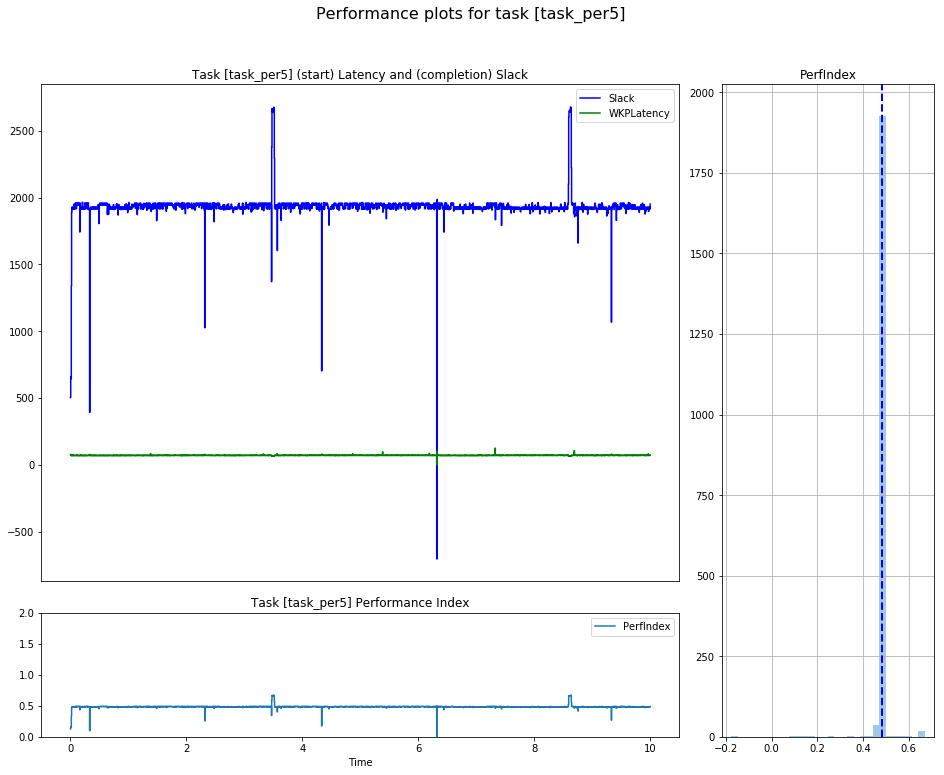

In [66]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [67]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:27:31,364 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-01-19 11:27:31,365 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:27:31,367 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f84b186a510> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f84b1000f50> from cache, reading it from trace
  warnings.warn(

2018-01-19 11:27:32,107 DEBUG   : Trace        :    cluster_idle_state_residency
2018-01-19 11:27:32,108 DEBUG   : Trace        :    cpu_idle_state_residency
2018-01-19 11:27:32,109 DEBUG   : Trace        :    trace_event
2018-01-19 11:27:32,110 DEBUG   : Analysis     :    idle
2018-01-19 11:27:32,110 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:27:32,111 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f84e8229850>] local data frames
2018-01-19 11:27:32,113 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:27:32,114 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:27:32,115 DEBUG   : Trace        :    trace_event
2018-01-19 11:27:32,116 DEBUG   : Analysis     :    frequency
2018-01-19 11:27:32,121 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:27:32,123 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f84c283e250>] local data frames

In [68]:
analysis_energy_calculation_duration()

,max,mean,min
0,39584,7999,2083


# 30% Workload

In [69]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=30,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:27:32,256 INFO    : Workload     : Setup new workload simple
2018-01-19 11:27:32,338 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:27:32,340 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:27:32,345 INFO    : Workload     : ------------------------
2018-01-19 11:27:32,347 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:27:32,349 INFO    : Workload     :  | loops count: 1
2018-01-19 11:27:32,351 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:27:32,353 INFO    : Workload     : |  period     5000 [us], duty_cycle  30 %
2018-01-19 11:27:32,355 INFO    : Workload     : |  run_time   1500 [us], sleep_time   3500 [us]


In [70]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:27:32,433 INFO    : root         : #### Setup FTrace
2018-01-19 11:27:35,559 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:27:35,646 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:27:35,754 INFO    : root         : #### Start energy sampling
2018-01-19 11:27:35,755 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-jb1Kod
2018-01-19 11:27:35,768 INFO    : root         : #### Start RTApp execution
2018-01-19 11:27:35,772 INFO    : Workload     : Workload execution START:
2018-01-19 11:27:35,774 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:27:45,933 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-01-19 11:27:45,935 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-jb1Kod/0000000000
2018-01-19 11:27:46,288 INFO    : root         : #### Stop FTrace
2018-01-19 11:27:46,289 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:27:46,537 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-01-19 11:27:48,432 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [71]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-01-19 11:27:49,734 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:27:49,735 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:27:49,983 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.36, std: 0.03


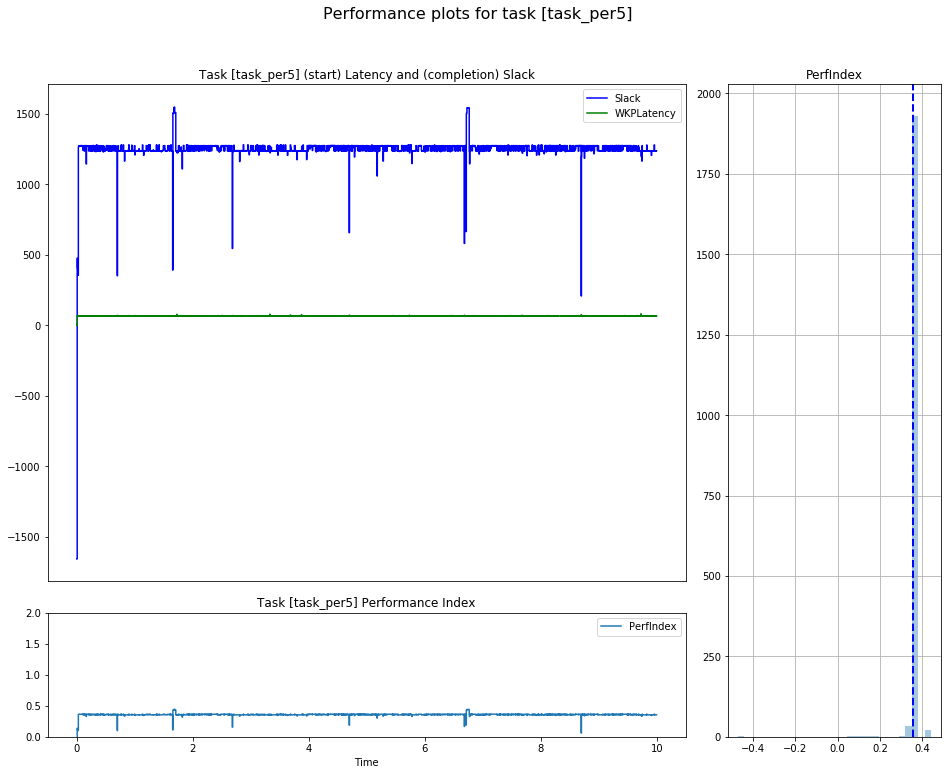

In [72]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [73]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:27:50,933 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-01-19 11:27:50,937 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:27:50,941 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f84b0063150> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f84b0063810> from cache, reading it fro

2018-01-19 11:27:51,648 DEBUG   : Trace        : Registering [<idle_analysis.IdleAnalysis object at 0x7f84b0e6d5d0>] local data frames
2018-01-19 11:27:51,653 DEBUG   : Trace        :    cluster_idle_state_residency
2018-01-19 11:27:51,655 DEBUG   : Trace        :    cpu_idle_state_residency
2018-01-19 11:27:51,657 DEBUG   : Trace        :    trace_event
2018-01-19 11:27:51,659 DEBUG   : Analysis     :    idle
2018-01-19 11:27:51,661 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:27:51,662 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f84b0e6dc90>] local data frames
2018-01-19 11:27:51,664 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:27:51,665 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:27:51,666 DEBUG   : Trace        :    trace_event
2018-01-19 11:27:51,668 DEBUG   : Analysis     :    frequency
2018-01-19 11:27:51,669 DEBUG   : Analysis     : Filename: latency_analysis
2018-

In [74]:
analysis_energy_calculation_duration()

,max,mean,min
0,30209,7210,1563


# 40% Workload

In [75]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=40,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:27:51,805 INFO    : Workload     : Setup new workload simple
2018-01-19 11:27:51,883 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:27:51,884 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:27:51,885 INFO    : Workload     : ------------------------
2018-01-19 11:27:51,887 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:27:51,888 INFO    : Workload     :  | loops count: 1
2018-01-19 11:27:51,890 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:27:51,892 INFO    : Workload     : |  period     5000 [us], duty_cycle  40 %
2018-01-19 11:27:51,894 INFO    : Workload     : |  run_time   2000 [us], sleep_time   3000 [us]


In [76]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:27:51,950 INFO    : root         : #### Setup FTrace
2018-01-19 11:27:54,979 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:27:55,057 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:27:55,165 INFO    : root         : #### Start energy sampling
2018-01-19 11:27:55,166 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-jb1Kod
2018-01-19 11:27:55,182 INFO    : root         : #### Start RTApp execution
2018-01-19 11:27:55,185 INFO    : Workload     : Workload execution START:
2018-01-19 11:27:55,186 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:28:05,410 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/energy.json
2018-01-19 11:28:05,412 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-jb1Kod/0000000000
2018-01-19 11:28:05,773 INFO    : root         : #### Stop FTrace
2018-01-19 11:28:05,775 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:28:06,019 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat
2018-01-19 11:28:07,968 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/platform.json


In [77]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-01-19 11:28:09,137 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:28:09,138 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:28:09,354 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.51, std: 0.06


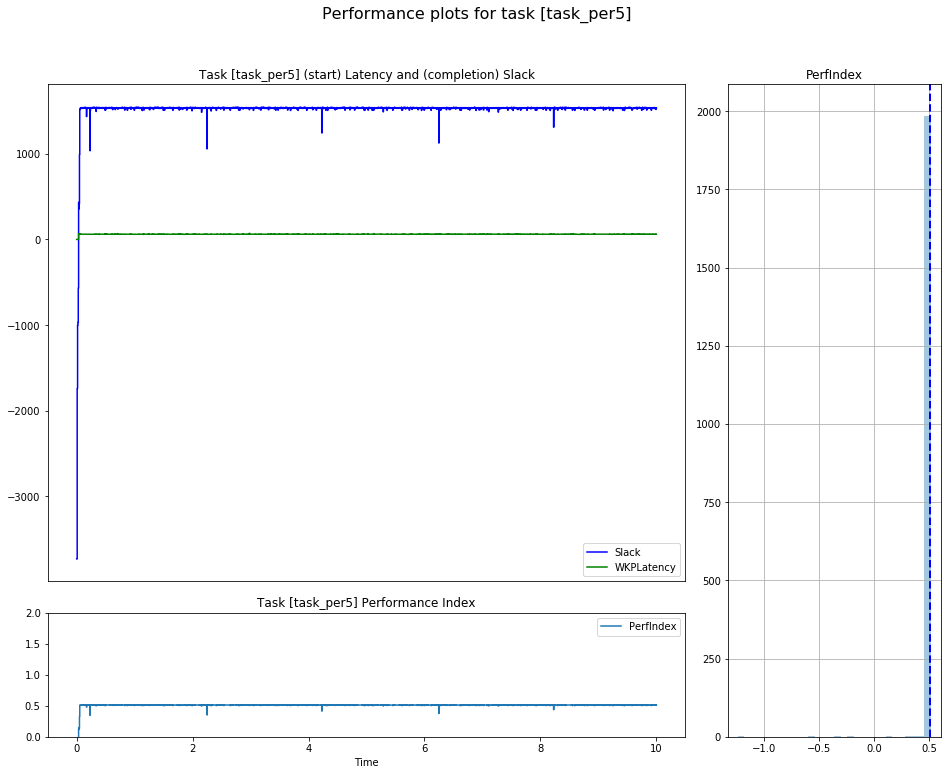

In [78]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [79]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:28:10,547 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_opt/trace.dat]...
2018-01-19 11:28:10,549 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:28:10,553 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f84b0f81c10> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f84b0e6dfd0> fr

2018-01-19 11:28:11,295 DEBUG   : Analysis     : Filename: idle_analysis
2018-01-19 11:28:11,296 DEBUG   : Trace        : Registering [<idle_analysis.IdleAnalysis object at 0x7f84f1484050>] local data frames
2018-01-19 11:28:11,297 DEBUG   : Trace        :    cluster_idle_state_residency
2018-01-19 11:28:11,299 DEBUG   : Trace        :    cpu_idle_state_residency
2018-01-19 11:28:11,300 DEBUG   : Trace        :    trace_event
2018-01-19 11:28:11,301 DEBUG   : Analysis     :    idle
2018-01-19 11:28:11,302 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:28:11,303 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f84f1484090>] local data frames
2018-01-19 11:28:11,305 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:28:11,306 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:28:11,307 DEBUG   : Trace        :    trace_event
2018-01-19 11:28:11,308 DEBUG   : Analysis     :    frequency
2018-01-

In [80]:
analysis_energy_calculation_duration()

,max,mean,min
0,35938,9538,1562
